# NON NEURAL NETWORK BINARY CLASSIFICATION OF IMAGES

#  Import Libraries

In [1]:
import os
import cv2
import numpy as np
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import os
import time
import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from skimage.feature import hog
from skimage import exposure
from skimage import color
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Load data

Steps done:
* resized the images to 300*300 for uniformity
* Grey scaled the images.
* Loaded as train_images, train_label,valid_images ,valid_labels.

In [2]:
train_path = "/kaggle/input/horses-or-humans-dataset/horse-or-human/train"
validation_path = "/kaggle/input/horses-or-humans-dataset/horse-or-human/validation"

In [3]:
# 1.Define a function called load_and_process_data to load and iterate through the images and 
#apply the hog extraction function defined above.(decided to do this separately later)
#2.Get the images and label data as separate numpy arrays.

def load_and_process_data(directory):
    # create lists to store images and labels
    images = []
    labels = []
    # Iterate through the main folder
    for root, dirs, files in os.walk(directory):
        # Access the name of the inner folder example: paper_boat folder
        f = os.path.basename(root)
        for file in files:
            # load the images
            try:
                img = cv2.imread(root+'/'+file)#read the image
                
                img = color.rgb2gray(img) #Convert the image to grayscale
                
                img = cv2.resize(img, (300,300))#resize all images to the same dimension
                
                #image_features = extract_hog_features(img)
                
                images.append(img)#append all the images into the images list
                
                labels.append(f)# Append the name of the inner folder
                
            # otherwise raise error 
            except Exception:
                print('Error could not load all images')
    
    #convert images to an array
    images = np.array(images)
    labels = np.array(labels)
    #return images and labels
    return (images, labels)

In [4]:
#Calling the above functions on the train and validation path

train_path = "/kaggle/input/horses-or-humans-dataset/horse-or-human/train"
validation_path = "/kaggle/input/horses-or-humans-dataset/horse-or-human/validation"

train_images, train_labels = load_and_process_data(train_path)
valid_images, valid_labels = load_and_process_data(validation_path)

# Exploratory Data Analysis

**a. Data Summary**

In [5]:
print(train_images.shape)
print(train_labels.shape)
print(valid_images.shape)
print(valid_labels.shape)
# 1027 train 300*300 sized grey scaled images in train set
# 256 train 300*300 sized grey scaled images in validation set

(1027, 300, 300)
(1027,)
(256, 300, 300)
(256,)


In [6]:
# To observe the unique categorical labels.we can see the labels are binary and categorical.
print(np.unique(train_labels))
print(np.unique(valid_labels))


['horses' 'humans']
['horses' 'humans']



**b. Visualise the data and check for class label imbalance**

Train Set - Horses: 500
Train Set - Humans: 527
Validation Set - Horses: 128
Validation Set - Humans: 128


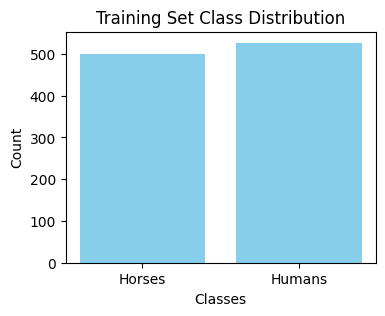

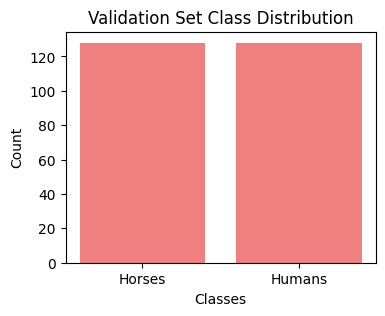

In [7]:
print("Train Set - Horses:",sum(train_labels == "horses") )
print("Train Set - Humans:",sum(train_labels == "humans") )
print("Validation Set - Horses:",sum(valid_labels == "horses") )
print("Validation Set - Humans:",sum(valid_labels == "humans") )

labels = ["Horses", "Humans"]
train_counts = [sum(train_labels == "horses"), sum(train_labels == "humans")]
valid_counts = [sum(valid_labels == "horses"), sum(valid_labels == "humans")]

# Plot training set class distribution
plt.figure(figsize=(4, 3))
plt.bar(labels, train_counts, color='skyblue')
plt.title("Training Set Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

# Plot validation set class distribution
plt.figure(figsize=(4, 3))
plt.bar(labels, valid_counts, color='lightcoral')
plt.title("Validation Set Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()


From the above graphs, we can see that the data is fairly balanced for both classes.

**Display 5 random images from the train_images and valid_images dataset.**

In [8]:

# Define a function to display sample images
def display_sample_images(images, labels, num_samples=5):
    # Create a figure with subplots
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    # Randomly select 'num_samples' indices
    sample_indices = np.random.choice(len(images), num_samples, replace=False)

    # Loop through and display the selected sample images
    for i, idx in enumerate(sample_indices):
        ax = axes[i]
        ax.imshow(images[idx], cmap='gray')  # Assuming the images are grayscale
        ax.set_title(labels[idx])
        ax.axis('off')
    plt.show()

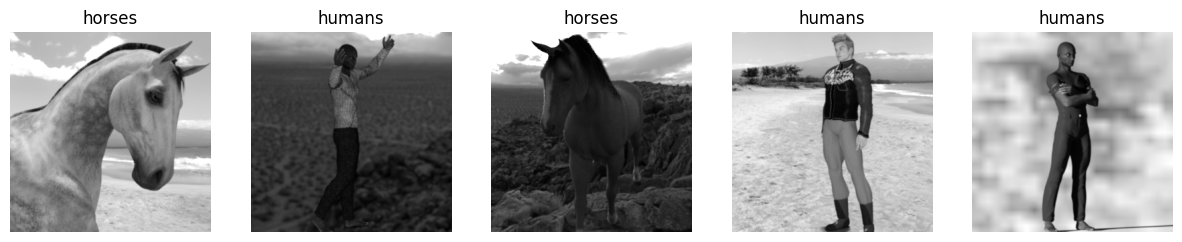

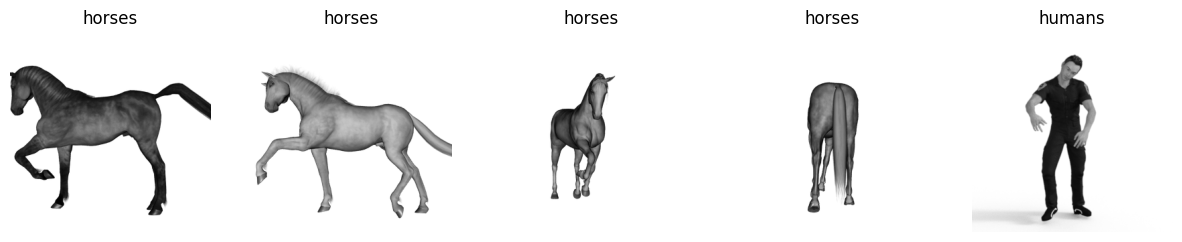

In [9]:
display_sample_images(train_images, train_labels, num_samples=5) # Display 5 random images from train dataset.
display_sample_images(valid_images, valid_labels, num_samples=5) # Display 5 random images from validation set.

In [10]:
#SANITY CHECK TO SEE ALL IMAGES HAVE THE SAME SIZE .I.E 300*300 PIXELS
train_image_shape = train_images[0].shape

# Check the shape of the first image in valid_images
valid_image_shape = valid_images[0].shape


In [11]:
# Function to check if all images have the same shape
def check_image_shapes(images):
    image_shapes = [image.shape for image in images]
    return all(shape == image_shapes[0] for shape in image_shapes)

# Check if all images in train_images have the same shape
train_images_same_shape = check_image_shapes(train_images)

# Check if all images in valid_images have the same shape
valid_images_same_shape = check_image_shapes(valid_images)

# Print the results
print("Shape of the first image in train_images:", train_image_shape)
print("Shape of the first image in valid_images:", valid_image_shape)
print("Are all images in train_images of the same shape?", train_images_same_shape)
print("Are all images in valid_images of the same shape?", valid_images_same_shape)

Shape of the first image in train_images: (300, 300)
Shape of the first image in valid_images: (300, 300)
Are all images in train_images of the same shape? True
Are all images in valid_images of the same shape? True


# Feature Engineering

Feature engineering is crucial when using non-neural network approaches for image classification.Images needs to be transformed into a suitable feature representation. libraries like OpenCV, Hog extraction can be explored. Additionally, hyperparameter tuning is essential to achieve the best possible results with these algorithms.Image classification with SVMs often requires careful feature engineering, as SVMs do not automatically learn hierarchical features like deep neural networks.Experimentation and iteration are expected to be required to achieve the best results with SVM.

In [12]:
from skimage.feature import hog
import numpy as np

def extract_hog_features(images):
    # Initialize an empty list to store the HOG features for each image
    hog_features_list = []

    for image in images:
        # Extract HOG features for each grayscale image
        features = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)

        # Append the HOG features to the list
        hog_features_list.append(features)

    # Convert the list of HOG features to a NumPy array
    hog_features_array = np.array(hog_features_list)

    return hog_features_array



In [13]:
# Apply HOG feature extraction to the train_images dataset (assuming it's a dataset of grayscale images)
train_images_hog = extract_hog_features(train_images)
valid_images_hog = extract_hog_features(valid_images)

In [14]:
#Print the shape and datatype of the final HOG feature dataset
print("Shape of the train images after hog extraction: " +str(train_images_hog.shape))
print("Shape of the valid images after hog extraction: " +str(valid_images_hog.shape))
print("The train images are now extracted as features of datatype: " + str(type(train_images_hog)))
print("The validation images are now extracted as features of datatype: " + str(type(valid_images_hog)))

Shape of the train images after hog extraction: (1027, 46656)
Shape of the valid images after hog extraction: (256, 46656)
The train images are now extracted as features of datatype: <class 'numpy.ndarray'>
The validation images are now extracted as features of datatype: <class 'numpy.ndarray'>


From above code we can see that 46656 numerical features are extracted from each image.

# Data Normalisation

SVM is sensitive to the scale of the data.The choice of scaling technique will depend on the distribution of the features.

The general practice is as follows:
a)If the data follows normal distribution. - StandardScaler -This centers the data
b)If the data is in a range - MinMaxScaler - scales the features between [0,1]
c)Robust Scaler - To handle Outlier
d) Log transformation - For highly skewed data.

The choice of normalization method should be based on the distribution and characteristics of your data. It's a good practice to visualize the distribution of your features and choose the normalization technique that best suits your data.
Before applying PCA, you should scale your features. Scaling ensures that all features have the same scale and prevents features with larger values from dominating the principal components.

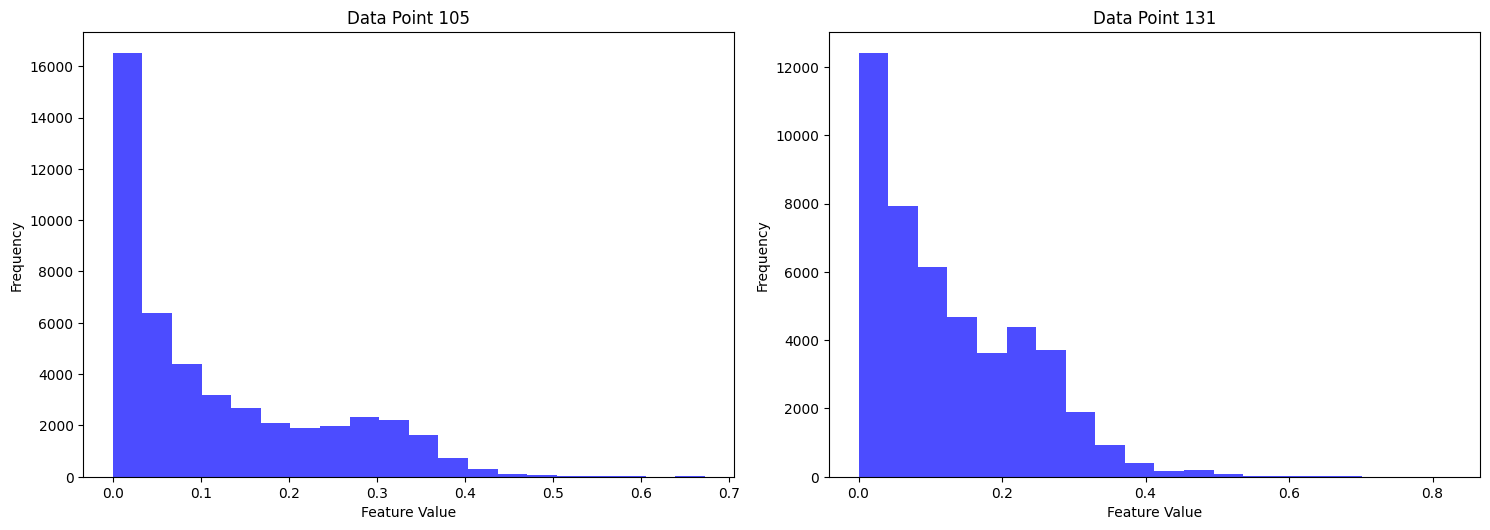

In [15]:
#VISUALISE THE HISTOGRAM OF TWO RANDOM DATAPOINTS FROM THE TRAIN_IMAGES_HOG DATASET.
import matplotlib.pyplot as plt
import numpy as np

# Select 5 random data points
num_data_points_to_visualize = 2
random_data_indices = np.random.choice(train_images_hog.shape[0], num_data_points_to_visualize, replace=False)

# Create subplots to visualize the selected data points' features with histograms
num_bins = 20  # Number of bins for the histograms

plt.figure(figsize=(15, 10))

for i, data_index in enumerate(random_data_indices):
    data_features = train_images_hog[data_index, :]

    plt.subplot(2, num_data_points_to_visualize, i + 1)
    plt.hist(data_features, bins=num_bins, color='b', alpha=0.7)
    plt.title(f'Data Point {data_index}')
    plt.xlabel('Feature Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


From above visualisation, the features seem to be skewed and right tailed.The following techniques can be tested for scaling the features.

1)Log transformation (Since the feature values are right tailed)

2)StandardScaler (Go to- choice for SVM)

a. Log_transformation

In [16]:
epsilon = 1e-6
# Apply the log transformation to the training dataset
train_images_hog_log = np.log1p(train_images_hog + epsilon)  # Log transformation with adding 1 to avoid log(0)

# Apply the same log transformation to the validation dataset
valid_images_hog_log = np.log(valid_images_hog + epsilon)

b. StandardScaler

In [17]:
scaler = StandardScaler()

# Fit the scaler on the training dataset and transform the data
train_images_hog_scaled = scaler.fit_transform(train_images_hog)

# Use the same scaler to transform the validation dataset
valid_images_hog_scaled = scaler.transform(valid_images_hog)

        
1. Data after applying StandardScaler:**train_images_hog_scaled, valid_images_hog_scaled**
1. Data after applying Logtransformation:**train_images_hog_log,valid_images_hog_log**

# Principal Component Analysis (Dimentionality Reduction)

We can see that the dataset is having 46656 features for each image.Working with these many features can be computationally intensive. PCA can be used to reduce the dimensions of the data by retaining the features across the direction of maximum varience.

Note: PCA is scale sensitive, therefore PCA is done after the scaling of the data and not vice-versa.

**1.PCA FOR SCALED DATA**

In [18]:
import numpy as np
from sklearn.decomposition import PCA

# Initialize PCA with a large number of components
pca1 = PCA(random_state =42)

# Fit PCA on the scaled training data
pca1.fit(train_images_hog_scaled)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca1.explained_variance_ratio_)

# Find the number of components that explain 95% of the variance
n_components = np.argmax(cumulative_variance >= 0.95) + 1

# Create a new PCA instance with the determined number of components
pca1 = PCA(n_components=n_components, random_state =42)

# Fit PCA on the scaled training data again with the selected number of components
pca1.fit(train_images_hog_scaled)

# Now, you can transform both the training and validation datasets using this PCA model
train_data_pca1 = pca1.transform(train_images_hog_scaled)
valid_data_pca1 = pca1.transform(valid_images_hog_scaled)

# n_components now contains the number of principal components needed to explain 95% of the variance

In [19]:
print(n_components)

823


In [20]:
print(train_data_pca1.shape)
print(valid_data_pca1.shape)

(1027, 823)
(256, 823)


Data with 46656 features has been scaled and applied with dimensionality reduction technique-PCA.823 components have been selected to retain 95% of the total variance,using scikit-learn's PCA and by performing a cumulative explained variance analysis.

**2. PCA FOR LOG TRANSFORMED DATA**

In [21]:
pca2 = PCA(random_state =42)
# Fit PCA on the scaled training data
pca2.fit(train_images_hog_log)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca2.explained_variance_ratio_)

# Find the number of components that explain 95% of the variance
n_components = np.argmax(cumulative_variance >= 0.95) + 1

# Create a new PCA instance with the determined number of components
pca2 = PCA(n_components=n_components,random_state =42)

# Fit PCA on the scaled training data again with the selected number of components
pca2.fit(train_images_hog_scaled)
train_data_pca2 = pca2.transform(train_images_hog_log)
valid_data_pca2 = pca2.transform(valid_images_hog_log)

In [22]:
print(n_components)

818


In [23]:
print(train_data_pca2.shape)
print(valid_data_pca2.shape)

(1027, 818)
(256, 818)


Data with 46656 features has been applied with log transformation and applied with dimensionality reduction technique-PCA.818 components have been selected to retain 95% of the total variance,using scikit-learn's PCA and by performing a cumulative explained variance analysis.

**3.PCA FOR SCALED DATA- ARBITRARY N_COMPONENTS**

In [24]:
pca3 = PCA(n_components = 100,random_state = 42)
pca3.fit(train_images_hog_scaled)
train_data_pca3 = pca3.transform(train_images_hog_scaled)
valid_data_pca3 = pca3.transform(valid_images_hog_scaled)

**4.PCA FOR LOG DATA - ARBITRARY N_COMPONENTS**

In [25]:
pca4 = PCA(n_components = 1027, random_state =42)
pca4.fit(train_images_hog_log)
train_data_pca4 = pca4.transform(train_images_hog_log)
valid_data_pca4 = pca4.transform(valid_images_hog_log)

In [26]:
print(pca4.n_components)

1027


In the above code:PCA is fitted on train data and applied on train and validation data.

* pca1 = PCA applied for data after StandardScaler. n_components(max_varience) =823
* pca2 = PCA applied for data after log transformation. n_components(max_varience) =818
* pca3 = PCA applied for data after StandardScaler. n_components(arbitrary) =100
* pca4 = PCA applied for data after log transformation. n_components(arbitrary) =1027

NOTE: by having 4 cases of data, i can test the accuracy for 4 data


NOTE ON random_state :Without specifying random_state, PCA (and many other algorithms) may use different random seeds or sources of randomness, resulting in slightly different results each time the model is being fit, even if the same data and parameters were used.Setting random_state ensures consistent results, which is helpful for debugging and comparing different runs or models.


# Label Encoding of the classes

In [27]:
# Encoding the categorical labels into numerical labels
le = LabelEncoder()
train_labels_enc = le.fit_transform(train_labels)
valid_labels_enc = le.fit_transform(valid_labels)

In [28]:
#the classes humans and horses are encoded as 1 and 0 respectively
print(train_labels[:10])
print(train_labels_enc[:10])

['humans' 'humans' 'humans' 'humans' 'humans' 'humans' 'humans' 'humans'
 'humans' 'humans']
[1 1 1 1 1 1 1 1 1 1]


**Split the train dataset into train and test.**

4 sets of train and valid sets are resulted after 2 types data preprocessing(StandardScaler&log) and 2 cases of PCA

In [29]:
#FOR SCALED,PCA,n_components - max varience
X_train1, X_test1, y_train1, y_test1 = train_test_split(train_data_pca1, train_labels_enc, test_size=0.2, random_state=42)

In [30]:
#FOR LOG,PCA, n_components - max varience
X_train2, X_test2, y_train2, y_test2 = train_test_split(train_data_pca2, train_labels_enc, test_size=0.2, random_state=42)

In [31]:
#FOR SCALED,PCA,n-arbitrary =100
X_train3, X_test3, y_train3, y_test3 = train_test_split(train_data_pca3, train_labels_enc, test_size=0.2, random_state=42)

In [32]:
#FOR LOG,PCA,n-arbitrary = 1027
X_train4, X_test4, y_train4, y_test4 = train_test_split(train_data_pca4, train_labels_enc, test_size=0.2, random_state=42)

In [33]:
print(X_train4.shape)
print(X_test4.shape)
print(y_train4.shape)
print(y_test4.shape)

print(valid_data_pca4.shape)
print(valid_labels_enc.shape)

(821, 1027)
(206, 1027)
(821,)
(206,)
(256, 1027)
(256,)


# MODEL TRAINING

**1.SUPPORT VECTOR CLASSIFICATION- with kernel = Linear**

PART A : WITH SCALED DATA,PCA APPLIED, n_components = max_varience

In [34]:
from sklearn.svm import SVC
clf1 = SVC(kernel = "linear", random_state =42)
clf1.fit(X_train1, y_train1)

y_pred1 = clf1.predict(X_test1)
accuracy = accuracy_score(y_test1, y_pred1)
print(f"Accuracy of the Linear SVC model: {accuracy}")

y_pred_val1 = clf1.predict(valid_data_pca1)
accuracy = accuracy_score(valid_labels_enc,y_pred_val1)
print(f"Accuracy with Validation set: {accuracy}")

Accuracy of the Linear SVC model: 0.970873786407767
Accuracy with Validation set: 0.16015625


The significant drop in accuarcy on the validation set indicates overfitting on the train data.

PART B - WITH LOG TRANSFORMED DATA,PCA APPLIED - n_components=max varince

In [35]:
clf2 = SVC(kernel = "linear",random_state = 42)
clf2.fit(X_train2, y_train2)

y_pred2 = clf2.predict(X_test2)
accuracy = accuracy_score(y_test2, y_pred2)
print(f"Accuracy of the Linear SVC model: {accuracy}")

y_pred_val2 = clf2.predict(valid_data_pca2)
accuracy = accuracy_score(valid_labels_enc,y_pred_val2)
print(f"Accuracy of Validation set: {accuracy}")

Accuracy of the Linear SVC model: 0.9757281553398058
Accuracy of Validation set: 0.34375


There is an improvement in accuracy for validation set(36.32%) for log transformed data.this implies the overfitting is less severe for log transformed data compared to data applied with standardscaler 

PART C : WITH SCALED DATA,PCA APPLIED, n_components = arbitrary(100)

In [36]:
from sklearn.svm import SVC
clf3 = SVC(kernel = "linear", random_state =42)
clf3.fit(X_train3, y_train3)

y_pred3 = clf3.predict(X_test3)
accuracy = accuracy_score(y_test3, y_pred3)
print(f"Accuracy of the Linear SVC model: {accuracy}")

y_pred_val3 = clf3.predict(valid_data_pca3)
accuracy = accuracy_score(valid_labels_enc,y_pred_val3)
print(f"Accuracy with Validation set: {accuracy}")

Accuracy of the Linear SVC model: 0.9466019417475728
Accuracy with Validation set: 0.34765625


Increase in accuracy with standardscaler +pca with n_components =100

PART D - WITH LOG TRANSFORMED DATA,PCA APPLIED - n_components= arbitrary(100)

In [37]:
clf4 = SVC(kernel = "linear",random_state = 42)
clf4.fit(X_train4, y_train4)

y_pred4 = clf4.predict(X_test4)
accuracy = accuracy_score(y_test4, y_pred4)
print(f"Accuracy of the Linear SVC model: {accuracy}")

y_pred_val4 = clf4.predict(valid_data_pca4)
accuracy = accuracy_score(valid_labels_enc,y_pred_val4)
print(f"Accuracy of Validation set: {accuracy}")

Accuracy of the Linear SVC model: 0.970873786407767
Accuracy of Validation set: 0.359375


Out of all the four cases,higest accuracy for linear SVC observed for data with log transformation + pca with n_components =1027 (PART D).clf 4 used data that was applied with log transformation.



# HYPERPARAMETER TUNING

**EXPLORE HYPERPARAMETER TUNING FOR LINEAR SVC.**

Hyperparameters of SVC that can be tuned:

1)REGULARIZATION PARAMETER (reduces overfitting of the model)
2)KERNEL - To deal with non linear decision boundaries.
3)DEGREE(for polynomial kernel(poly) function )
4)GAMMA (for rbf kernel)
5)COEFF0 (for polynomial and sigmoid kernel)
6)MAX-ITER

1. Tuning regularization parameter C for SVC(kernel ='linear') for all 4 sets of train and valid datasets.

In [38]:
def perform_grid_search(X_train, y_train, X_test, y_test, valid_data_pca, valid_labels_enc,datano):
    print("RESULTS FOR SVC(linear kernel) AFTER TUNING C VALUES WITH DATASET-" + str(datano))
    print("")

    C_values = [0.001, 0.01, 0.1, 1, 10, 100]
    param_grid = {'C': C_values}
    
    # Create an SVC with a linear kernel
    clf = SVC(kernel='linear')

    # Perform grid search
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Get the best parameters and the best estimator
    best_C = grid_search.best_params_['C']
    best_clf = grid_search.best_estimator_

    print("The best value for C with linear kernel is: " + str(best_C))
    print(best_clf)

    # Test accuracy on the test set
    test_accuracy = best_clf.score(X_test, y_test)
    print("Test accuracy is: " + str(test_accuracy))

    # Predict on the validation set
    y_pred_val = best_clf.predict(valid_data_pca)
    valid_accuracy = accuracy_score(valid_labels_enc, y_pred_val)
    print("Accuracy on the validation set is: " + str(valid_accuracy))
    print("")

    return y_pred_val, test_accuracy

# Example usage for dataset 1
y_pred_val1, test_accuracy1 = perform_grid_search(X_train1, y_train1, X_test1, y_test1, valid_data_pca1, valid_labels_enc,1)

# Example usage for dataset 2
y_pred_val2, test_accuracy2 = perform_grid_search(X_train2, y_train2, X_test2, y_test2, valid_data_pca2, valid_labels_enc,2)

# Repeat for dataset 3 and 4 as needed
y_pred_val3, test_accuracy3 = perform_grid_search(X_train3, y_train3, X_test3, y_test3, valid_data_pca3, valid_labels_enc,3)
y_pred_val4, test_accuracy4 = perform_grid_search(X_train4, y_train4, X_test4, y_test4, valid_data_pca4, valid_labels_enc,4)

RESULTS FOR SVC(linear kernel) AFTER TUNING C VALUES WITH DATASET-1

The best value for C with linear kernel is: 0.001
SVC(C=0.001, kernel='linear')
Test accuracy is: 0.970873786407767
Accuracy on the validation set is: 0.16015625

RESULTS FOR SVC(linear kernel) AFTER TUNING C VALUES WITH DATASET-2

The best value for C with linear kernel is: 0.01
SVC(C=0.01, kernel='linear')
Test accuracy is: 0.9757281553398058
Accuracy on the validation set is: 0.34375

RESULTS FOR SVC(linear kernel) AFTER TUNING C VALUES WITH DATASET-3

The best value for C with linear kernel is: 0.001
SVC(C=0.001, kernel='linear')
Test accuracy is: 0.970873786407767
Accuracy on the validation set is: 0.2421875

RESULTS FOR SVC(linear kernel) AFTER TUNING C VALUES WITH DATASET-4

The best value for C with linear kernel is: 0.01
SVC(C=0.01, kernel='linear')
Test accuracy is: 0.970873786407767
Accuracy on the validation set is: 0.359375



In [39]:
def perform_grid_search(X_train, y_train, X_test, y_test, valid_data_pca, valid_labels_enc,datano):
    print("RESULTS FOR SVC(polynomial kernel) AFTER TUNING C VALUES WITH DATASET-" + str(datano))
    print("")

    C_values = [0.001, 0.01, 0.1, 1, 10, 100]
    degree_values = [2,3,4]
    param_grid = {'degree': degree_values,'C': C_values}
    
    # Create an SVC with a linear kernel
    clf = SVC(kernel='poly')

    # Perform grid search
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Get the best parameters and the best estimator
    best_C = grid_search.best_params_['C']
    best_clf2 = grid_search.best_estimator_

    print("The best value for C with polynomial kernel is: " + str(best_C))
    print(best_clf2)
    print(grid_search.best_params_['degree'])

    # Test accuracy on the test set
    test_accuracy = best_clf2.score(X_test, y_test)
    print("Test accuracy is: " + str(test_accuracy))

    # Predict on the validation set
    y_pred_val = best_clf2.predict(valid_data_pca)
    valid_accuracy = accuracy_score(valid_labels_enc, y_pred_val)
    print("Accuracy on the validation set is: " + str(valid_accuracy))
    print("")

    return y_pred_val, test_accuracy

# Example usage for dataset 1
y_pred_val1, test_accuracy1 = perform_grid_search(X_train1, y_train1, X_test1, y_test1, valid_data_pca1, valid_labels_enc,1)

# Example usage for dataset 2
y_pred_val2, test_accuracy2 = perform_grid_search(X_train2, y_train2, X_test2, y_test2, valid_data_pca2, valid_labels_enc,2)

# Repeat for dataset 3 and 4 as needed
y_pred_val3, test_accuracy3 = perform_grid_search(X_train3, y_train3, X_test3, y_test3, valid_data_pca3, valid_labels_enc,3)
y_pred_val4, test_accuracy4 = perform_grid_search(X_train4, y_train4, X_test4, y_test4, valid_data_pca4, valid_labels_enc,4)

RESULTS FOR SVC(polynomial kernel) AFTER TUNING C VALUES WITH DATASET-1

The best value for C with polynomial kernel is: 10
SVC(C=10, degree=2, kernel='poly')
2
Test accuracy is: 0.9757281553398058
Accuracy on the validation set is: 0.5

RESULTS FOR SVC(polynomial kernel) AFTER TUNING C VALUES WITH DATASET-2

The best value for C with polynomial kernel is: 10
SVC(C=10, degree=2, kernel='poly')
2
Test accuracy is: 0.9660194174757282
Accuracy on the validation set is: 0.73046875

RESULTS FOR SVC(polynomial kernel) AFTER TUNING C VALUES WITH DATASET-3

The best value for C with polynomial kernel is: 10
SVC(C=10, degree=2, kernel='poly')
2
Test accuracy is: 0.9951456310679612
Accuracy on the validation set is: 0.5

RESULTS FOR SVC(polynomial kernel) AFTER TUNING C VALUES WITH DATASET-4

The best value for C with polynomial kernel is: 10
SVC(C=10, degree=2, kernel='poly')
2
Test accuracy is: 0.9660194174757282
Accuracy on the validation set is: 0.53125



In [40]:
def perform_grid_search(X_train, y_train, X_test, y_test, valid_data_pca, valid_labels_enc,datano):
    print("RESULTS FOR SVC(rbf kernel) AFTER TUNING C VALUES WITH DATASET-" + str(datano))
    print("")

    C_values = [0.001, 0.01, 0.1, 1, 10, 100]
    gamma_values = [0.001, 0.01, 0.1, 1, 10]
    param_grid = {'gamma': gamma_values,'C': C_values}
    
    # Create an SVC with a linear kernel
    clf = SVC(kernel='rbf')

    # Perform grid search
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Get the best parameters and the best estimator
    best_C = grid_search.best_params_['C']
    best_clf = grid_search.best_estimator_

    print("The best value for C with rbf kernel is: " + str(best_C))
    print(best_clf)
    print(grid_search.best_params_['gamma'])

    # Test accuracy on the test set
    test_accuracy = best_clf.score(X_test, y_test)
    print("Test accuracy is: " + str(test_accuracy))

    # Predict on the validation set
    y_pred_val = best_clf.predict(valid_data_pca)
    valid_accuracy = accuracy_score(valid_labels_enc, y_pred_val)
    print("Accuracy on the validation set is: " + str(valid_accuracy))
    print("")

    return y_pred_val, test_accuracy

# Example usage for dataset 1
y_pred_val1, test_accuracy1 = perform_grid_search(X_train1, y_train1, X_test1, y_test1, valid_data_pca1, valid_labels_enc,1)

# Example usage for dataset 2
y_pred_val2, test_accuracy2 = perform_grid_search(X_train2, y_train2, X_test2, y_test2, valid_data_pca2, valid_labels_enc,2)

# Repeat for dataset 3 and 4 as needed
y_pred_val3, test_accuracy3 = perform_grid_search(X_train3, y_train3, X_test3, y_test3, valid_data_pca3, valid_labels_enc,3)
y_pred_val4, test_accuracy4 = perform_grid_search(X_train4, y_train4, X_test4, y_test4, valid_data_pca4, valid_labels_enc,4)

RESULTS FOR SVC(rbf kernel) AFTER TUNING C VALUES WITH DATASET-1

The best value for C with rbf kernel is: 10
SVC(C=10, gamma=0.001)
0.001
Test accuracy is: 0.5679611650485437
Accuracy on the validation set is: 0.5

RESULTS FOR SVC(rbf kernel) AFTER TUNING C VALUES WITH DATASET-2

The best value for C with rbf kernel is: 10
SVC(C=10, gamma=0.001)
0.001
Test accuracy is: 0.9611650485436893
Accuracy on the validation set is: 0.5

RESULTS FOR SVC(rbf kernel) AFTER TUNING C VALUES WITH DATASET-3

The best value for C with rbf kernel is: 10
SVC(C=10, gamma=0.001)
0.001
Test accuracy is: 0.7864077669902912
Accuracy on the validation set is: 0.5

RESULTS FOR SVC(rbf kernel) AFTER TUNING C VALUES WITH DATASET-4

The best value for C with rbf kernel is: 10
SVC(C=10, gamma=0.001)
0.001
Test accuracy is: 0.9563106796116505
Accuracy on the validation set is: 0.5



In [41]:
def perform_grid_search(X_train, y_train, X_test, y_test, valid_data_pca, valid_labels_enc,datano):
    print("RESULTS FOR SVC(sigmoid kernel) AFTER TUNING C VALUES WITH DATASET-" + str(datano))
    print("")

    C_values = [0.001, 0.01, 0.1, 1, 10, 100]
    coef0_values = [-1, 0, 1]
    param_grid = {'coef0': coef0_values,'C': C_values}
    
    # Create an SVC with a linear kernel
    clf = SVC(kernel='sigmoid')

    # Perform grid search
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Get the best parameters and the best estimator
    best_C = grid_search.best_params_['C']
    best_clf = grid_search.best_estimator_

    print("The best value for C with sigmoid kernel is: " + str(best_C))
    print(best_clf)
    print(grid_search.best_params_['coef0'])

    # Test accuracy on the test set
    test_accuracy = best_clf.score(X_test, y_test)
    print("Test accuracy is: " + str(test_accuracy))

    # Predict on the validation set
    y_pred_val = best_clf.predict(valid_data_pca)
    valid_accuracy = accuracy_score(valid_labels_enc, y_pred_val)
    print("Accuracy on the validation set is: " + str(valid_accuracy))
    print("")

    return y_pred_val, test_accuracy

# Example usage for dataset 1
y_pred_val1, test_accuracy1 = perform_grid_search(X_train1, y_train1, X_test1, y_test1, valid_data_pca1, valid_labels_enc,1)

# Example usage for dataset 2
y_pred_val2, test_accuracy2 = perform_grid_search(X_train2, y_train2, X_test2, y_test2, valid_data_pca2, valid_labels_enc,2)

# Repeat for dataset 3 and 4 as needed
y_pred_val3, test_accuracy3 = perform_grid_search(X_train3, y_train3, X_test3, y_test3, valid_data_pca3, valid_labels_enc,3)
y_pred_val4, test_accuracy4 = perform_grid_search(X_train4, y_train4, X_test4, y_test4, valid_data_pca4, valid_labels_enc,4)

RESULTS FOR SVC(sigmoid kernel) AFTER TUNING C VALUES WITH DATASET-1

The best value for C with sigmoid kernel is: 10
SVC(C=10, coef0=0, kernel='sigmoid')
0
Test accuracy is: 0.9660194174757282
Accuracy on the validation set is: 0.13671875

RESULTS FOR SVC(sigmoid kernel) AFTER TUNING C VALUES WITH DATASET-2

The best value for C with sigmoid kernel is: 100
SVC(C=100, coef0=1, kernel='sigmoid')
1
Test accuracy is: 0.9660194174757282
Accuracy on the validation set is: 0.5

RESULTS FOR SVC(sigmoid kernel) AFTER TUNING C VALUES WITH DATASET-3

The best value for C with sigmoid kernel is: 10
SVC(C=10, coef0=-1, kernel='sigmoid')
-1
Test accuracy is: 1.0
Accuracy on the validation set is: 0.49609375

RESULTS FOR SVC(sigmoid kernel) AFTER TUNING C VALUES WITH DATASET-4

The best value for C with sigmoid kernel is: 10
SVC(C=10, coef0=0, kernel='sigmoid')
0
Test accuracy is: 0.9805825242718447
Accuracy on the validation set is: 0.5078125



 **After hyper parameter tuning, the best support vector model was achieved with SVC(kernel = 'poly', degree =2, C = 10), with a test accuracy of 96.6 and an accuracy of 73.04 on the unseen validation dataset. This shows a significant increase in the accuracy from the earlier 35% accuarcy achieved without hyperparameter tuning**

ROC CURVE

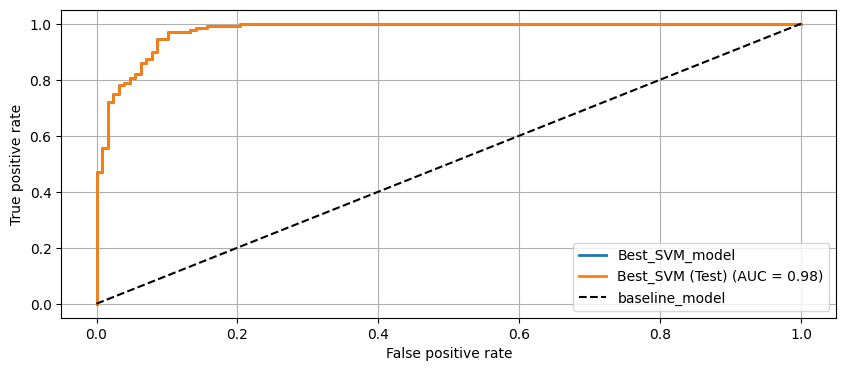

In [42]:
best_clf0 =SVC(C=10, degree=2, kernel='poly')
best_clf0.fit(X_train2,y_train2)
y_scores = best_clf0.decision_function(valid_data_pca2)
# Calculate the AUC for the test dataset
auc_test = roc_auc_score(valid_labels_enc, y_scores)
fpr, tpr, thresholds = roc_curve(valid_labels_enc, y_scores)
plt.figure(figsize = (10,4))
plt.plot(fpr,tpr,linewidth =2 ,label ='Best_SVM_model')
plt.plot(fpr, tpr, linewidth=2, label='Best_SVM (Test) (AUC = {:.2f})'.format(auc_test))
plt.plot([0,1],[0,1],'k--',label ='baseline_model')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.grid(True)
plt.legend()
plt.show()